In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import math
import random
import matplotlib.pyplot as plt
import numpy as np
import sys

In [2]:
IN_COLAB = 'google.colab' in sys.modules

In [3]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    proj_folder = "/content/drive/MyDrive/machine_learning/FYPTinyDiffusion/diffusion_winnet"

In [4]:
if IN_COLAB:
    sys.path.append(proj_folder)

## Prepare the Dataset

In [5]:
from denoising.dataset import NoisyImageDataset
from denoising.utils import sigmoid_noise_level, cosine_noise_level, plot_noisy_clean_images_with_labels

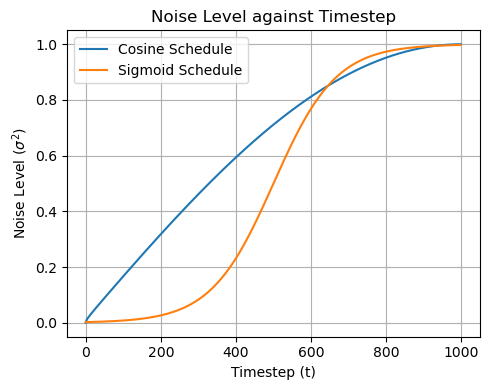

In [6]:
T_STEPS = 1000

timesteps = torch.arange(0, T_STEPS)
cosine_noise_vals = cosine_noise_level(timesteps, T_STEPS)
sigmoid_noise_vals = sigmoid_noise_level(timesteps, T_STEPS)

plt.figure(figsize=(5, 4))
plt.plot(timesteps.numpy(), cosine_noise_vals.numpy(), label="Cosine Schedule")
plt.plot(timesteps.numpy(), sigmoid_noise_vals.numpy(), label="Sigmoid Schedule")
plt.legend()
plt.xlabel("Timestep (t)")
plt.ylabel(r"Noise Level ($\sigma^2$)")
plt.title("Noise Level against Timestep")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
NUM_WORKERS = 4
BATCH_SIZE = 128
T_STEPS = 1000
DATASET_NAME = "FashionMNIST" # "FashionMNIST" or "CIFAR10"

In [8]:
train_ds = NoisyImageDataset(
    dataset=DATASET_NAME,
    replicate_chan=True,
    train=True,
    T=T_STEPS,
)

val_ds = NoisyImageDataset(
    dataset=DATASET_NAME,
    replicate_chan=True,
    train=False,
    T=T_STEPS,
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [9]:
noisy, t, clean = train_ds[random.randrange(len(train_ds))]

print(f"Noisy image shape: {noisy.shape}")
print(f"Clean image shape: {clean.shape}")

Noisy image shape: torch.Size([3, 32, 32])
Clean image shape: torch.Size([3, 32, 32])


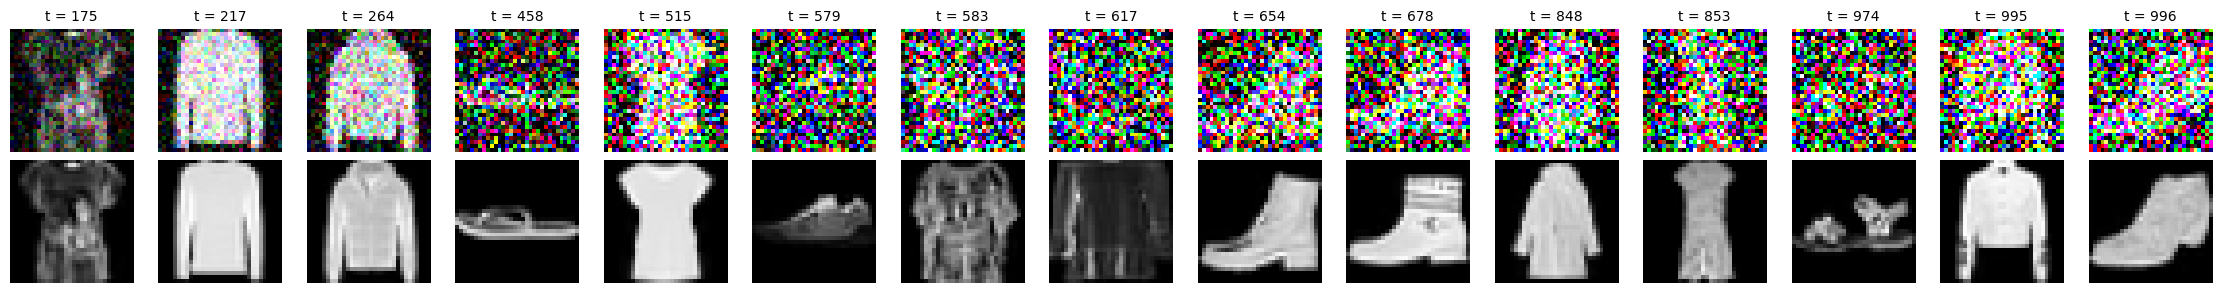

In [10]:
# Extract image pairs from the dataset
n_images = 15
noisy_images = []
clean_images = []
timesteps = []

for i in range(n_images):
    # Get a random sample from the dataset
    idx = random.randrange(len(train_ds))
    noisy, t, clean = train_ds[idx]

    # Append to lists
    noisy_images.append(noisy)
    clean_images.append(clean)
    timesteps.append(t)

# Plot using the function with labels
plot_noisy_clean_images_with_labels(noisy_images, clean_images, timesteps, n_cols=15)

## Train the Model

In [11]:
# train_denoiser.py
import time
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import MSELoss

In [12]:
T_STEPS = 1000
timestep_vals = torch.linspace(0, T_STEPS, T_STEPS)
sigma_vals = torch.sqrt(sigmoid_noise_level(timestep_vals, T_STEPS))

In [13]:
from models.lifting_denoiser import LiftingDenoiser
# from models.unet import UNet

In [14]:
# new LiftingDenoiser init params
clista_params = {
    "latent_channels": 128,
}

unet_params = {
    "base_channels": 16,
    "channel_multipliers": (1, 2, 4, 8),
}

init_params = {
    "input_channels": 3,
    "coarse_channels": 3,
    "hidden_channels": 128,
    "num_lifting_steps": 4,
    "lifting_type": "revnet",
    "detail_denoiser": "clista",
    "split_merge_type": "learnable",
    "do_convert_t_to_sigma": True,
    "num_learnable_filters": 6,
}

if init_params["detail_denoiser"] == "clista":
    init_params.update(clista_params)
elif init_params["detail_denoiser"] == "unet":
    init_params.update(unet_params)
else:
    raise ValueError("invalid detail_denoiser choice.")

for key, val in init_params.items():
    print(f"{key}: {val}")

input_channels: 3
coarse_channels: 3
hidden_channels: 128
num_lifting_steps: 4
lifting_type: revnet
detail_denoiser: clista
split_merge_type: learnable
do_convert_t_to_sigma: True
num_learnable_filters: 6
latent_channels: 128


In [15]:
# UNet init params

# init_params = {
#     "base_channels": 64,
#     "channel_multipliers": (1, 2, 4, 8),
#     "in_channels": 3,
# }

In [16]:
model = LiftingDenoiser(**init_params)

Updated sigma values successfully.
first 10 sigma values:
tensor([0.0497, 0.0500, 0.0503, 0.0506, 0.0509, 0.0512, 0.0515, 0.0519, 0.0522,
        0.0525])


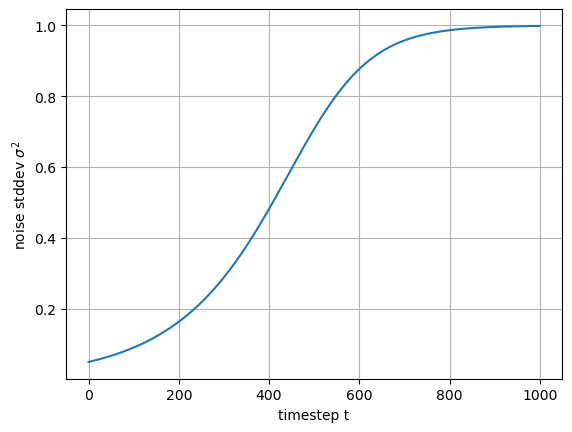

In [17]:
if hasattr(model, "update_sigmas_t"):
    model.update_sigmas_t(sigma_vals, "Updated sigma values successfully.")

    print(f"first 10 sigma values:\n{model.sigmas[:10]}")
    plt.plot(model.sigmas)
    plt.grid()
    plt.xlabel("timestep t")
    plt.ylabel(r"noise stddev $\sigma^2$")
    plt.show()

In [18]:
param_count = sum(p.numel() for p in model.parameters())
param_count

1677449

In [19]:
model

LiftingDenoiser(
  (split_merge): LearnableHaarSplitMerge(
    (analysis): Conv2d(3, 18, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), groups=3, bias=False)
    (synthesis): ConvTranspose2d(18, 3, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1), groups=3, bias=False)
  )
  (lifting_steps): ModuleList(
    (0-3): 4 x RevNetLiftingPair(
      (f): Conditioner(
        (b1): ConvFiLMBlock(
          (conv): Conv2d(15, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (gn): GroupNorm(8, 128, eps=1e-05, affine=False)
          (film): FiLM(
            (mlp): Sequential(
              (0): Linear(in_features=1, out_features=32, bias=True)
              (1): ReLU(inplace=True)
              (2): Linear(in_features=32, out_features=256, bias=True)
            )
          )
        )
        (b2): ConvFiLMBlock(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (gn): GroupNorm(8, 128, eps=1e-05, affine=False)
          (film)

In [20]:
EPOCHS = 20
LR = 1e-4

In [21]:
from denoising.train import train_denoiser
from denoising.loss import LiftingDenoiserLoss

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = model.to(device)
crit   = LiftingDenoiserLoss(
    reconstruction_weight=1.0,
    splitmerge_orthogonal_weight=1e-3,
    clista_orthogonal_weight=1e-3,
    spectral_norm_weight=1e-3,
)
opt    = AdamW(model.parameters(), lr=LR)

In [23]:
train_losses, val_losses = train_denoiser(
    model=model,
    device=device,
    crit=crit,
    opt=opt,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=EPOCHS,
    is_custom_loss_fn=True,
)

AttributeError: Can't pickle local object 'NoisyImageDataset.__init__.<locals>.<lambda>'

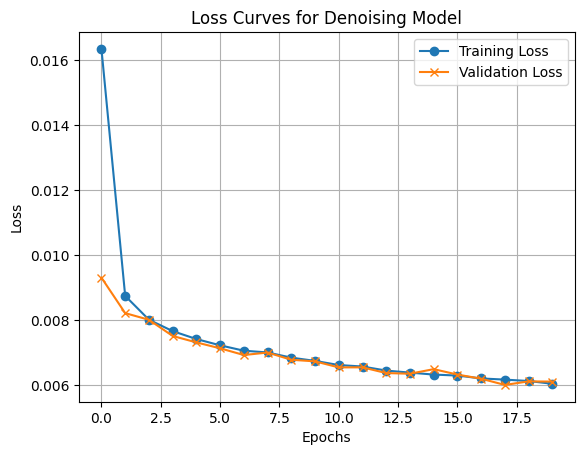

In [24]:
plt.figure()
plt.plot(train_losses, label="Training Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="x")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curves for Denoising Model")
plt.grid()
plt.legend()
plt.show()

## Saving the Model

In [25]:
from datetime import datetime
import json

In [26]:
model_type = model.__class__.__name__.lower()
model_type

'liftingdenoiser'

In [27]:
results_folder = f"drive/MyDrive/machine_learning/FYPTinyDiffusion/results/{DATASET_NAME.lower()}_denoising"
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%d%b_%H%M")
model_name = f"{DATASET_NAME.lower()}_{model_type}_{formatted_datetime}"
print(model_name)
CKPT_PATH = f"{results_folder}/{model_name}.pt"

fashionmnist_liftingdenoiser_10Jun_1208


In [28]:
model.eval()

# init_params is assumed to be a dict you created when instantiating the model
torch.save({"model_state_dict": model.state_dict(),
            "init_params": init_params},
           CKPT_PATH)
print(f"✓ checkpoint written to\n{CKPT_PATH}")

✓ checkpoint written to
drive/MyDrive/machine_learning/FYPTinyDiffusion/results/fashionmnist_denoising/fashionmnist_liftingdenoiser_10Jun_1208.pt


In [ ]:
# from google.colab import runtime
# runtime.unassign()

## Evaluate the Model

In [29]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image

import random
import matplotlib.pyplot as plt
import pandas as pd

from models.lifting_denoiser import LiftingDenoiser
from models.unet import UNet
from denoising.evaluate import (
    calculate_psnr,
    calculate_ssim,
    calculate_mse,
    plot_metrics_against_sigma
)

In [30]:
DATASET_NAME = "FashionMNIST"

In [33]:
results_folder = f"drive/MyDrive/machine_learning/FYPTinyDiffusion/results/{DATASET_NAME.lower()}_denoising"
model_name = "fashionmnist_liftingdenoiser_10Jun_1208"

In [34]:
CKPT_PATH = f"{results_folder}/{model_name}.pt"
T_STEPS    = 1_000
BATCH      = 256
NUM_WORKER = 4
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [35]:
# restore model + its init params
ckpt  = torch.load(CKPT_PATH, map_location=device)

if "unet" in model_name:
    model = UNet(**ckpt["init_params"]).to(device)
elif "lifting" in model_name:
    model = LiftingDenoiser(**ckpt["init_params"]).to(device)
else:
    raise ValueError(f"Unknown model type: {model_name}")

timestep_vals = torch.linspace(0, 1, T_STEPS)
sigma_vals = torch.sqrt(sigmoid_noise_level(timestep_vals, T_STEPS)).to(device)

if hasattr(model, "update_sigmas_t"):
    model.update_sigmas_t(sigma_vals, "Updated sigma vals successfully.")

model.load_state_dict(ckpt["model_state_dict"])
model.eval()
print("✓ model loaded")

Updated sigma vals successfully.
✓ model loaded


In [36]:
replicate_chan = True

In [37]:
if DATASET_NAME == "FashionMNIST":
    if replicate_chan:
        test_set = datasets.FashionMNIST(
            root="./data", train=False, download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32), interpolation=InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
            ])
        )
    else:
        test_set = datasets.FashionMNIST(
            root="./data", train=False, download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32), interpolation=InterpolationMode.BILINEAR),
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
            ])
        )
elif DATASET_NAME == "CIFAR10":
    test_set = datasets.CIFAR10(
        root="./data", train=False, download=True,
        transform=transforms.ToTensor()
    )
test_loader = DataLoader(
    test_set, batch_size=BATCH, shuffle=False,
    num_workers=NUM_WORKER, pin_memory=True
)

In [38]:
LEVELS = [0, 50, 100, 250, 500, 750, 999]        # diffusion steps to test
sigmas = [sigmoid_noise_level(torch.tensor(t), T_STEPS).sqrt().item()
          for t in LEVELS]

In [39]:
def eval_level(t_step: int):
    sigma = sigmoid_noise_level(torch.tensor(t_step), T_STEPS).sqrt()
    psnr_sum, ssim_sum, mse_sum, n_img = 0.0, 0.0, 0.0, 0

    with torch.no_grad():
        for clean, _ in test_loader:
            clean = clean.to(device)
            noisy = torch.clamp(clean + torch.randn_like(clean) * sigma, 0., 1.)

            pred  = model(noisy,
                          torch.full((noisy.size(0),), t_step,
                                     dtype=torch.long, device=device))

            psnr_sum += calculate_psnr(pred, clean).item()
            ssim_sum += calculate_ssim(pred, clean).item()
            mse_sum += calculate_mse(pred, clean).item()

        psnr_mean = psnr_sum / len(test_loader)
        ssim_mean = ssim_sum / len(test_loader)
        mse_mean = mse_sum / len(test_loader)

    return psnr_mean, ssim_mean, mse_mean

In [40]:
# 4.  EVALUATE & PRINT

metric_names_vals = {
    "t": LEVELS,
    "sigma": sigmas,
    "PSNR": [],
    "SSIM": [],
    "MSE": [],
}

for t, σ in zip(LEVELS, sigmas):
    p, s, mse = eval_level(t)
    metric_names_vals["PSNR"].append(p)
    metric_names_vals["SSIM"].append(s)
    metric_names_vals["MSE"].append(mse)
    print(f"t={t:4d} | σ={σ:.3f} | PSNR {p:.2f} dB | SSIM {s:.4f} | MSE {mse:.4f}")

t=   0 | σ=0.050 | PSNR 33.07 dB | SSIM 0.9512 | MSE 0.0005
t=  50 | σ=0.067 | PSNR 32.19 dB | SSIM 0.9482 | MSE 0.0006
t= 100 | σ=0.090 | PSNR 31.09 dB | SSIM 0.9398 | MSE 0.0008
t= 250 | σ=0.218 | PSNR 27.27 dB | SSIM 0.8887 | MSE 0.0020
t= 500 | σ=0.707 | PSNR 21.85 dB | SSIM 0.7535 | MSE 0.0071
t= 750 | σ=0.976 | PSNR 20.42 dB | SSIM 0.6941 | MSE 0.0099
t= 999 | σ=0.999 | PSNR 20.31 dB | SSIM 0.6880 | MSE 0.0102


In [41]:
import pandas as pd

In [42]:
df = pd.DataFrame.from_dict(metric_names_vals)
df

t     sigma       PSNR      SSIM       MSE
0    0  0.049725  33.071708  0.951190  0.000534
1   50  0.067054  32.189216  0.948206  0.000648
2  100  0.090347  31.086713  0.939752  0.000828
3  250  0.217775  27.271463  0.888729  0.002004
4  500  0.707107  21.853598  0.753473  0.007100
5  750  0.975999  20.417498  0.694130  0.009923
6  999  0.998748  20.307069  0.688030  0.010177

In [43]:
print(results_folder)
print(model_name)

drive/MyDrive/machine_learning/FYPTinyDiffusion/results/fashionmnist_denoising
fashionmnist_liftingdenoiser_10Jun_1208


In [44]:
# save the df as a csv file
csv_path = f"{results_folder}/{model_name}.csv"
df.to_csv(csv_path, index=False)
print(f"metrics dataframe saved to\n{csv_path}")

metrics dataframe saved to
drive/MyDrive/machine_learning/FYPTinyDiffusion/results/fashionmnist_denoising/fashionmnist_liftingdenoiser_10Jun_1208.csv


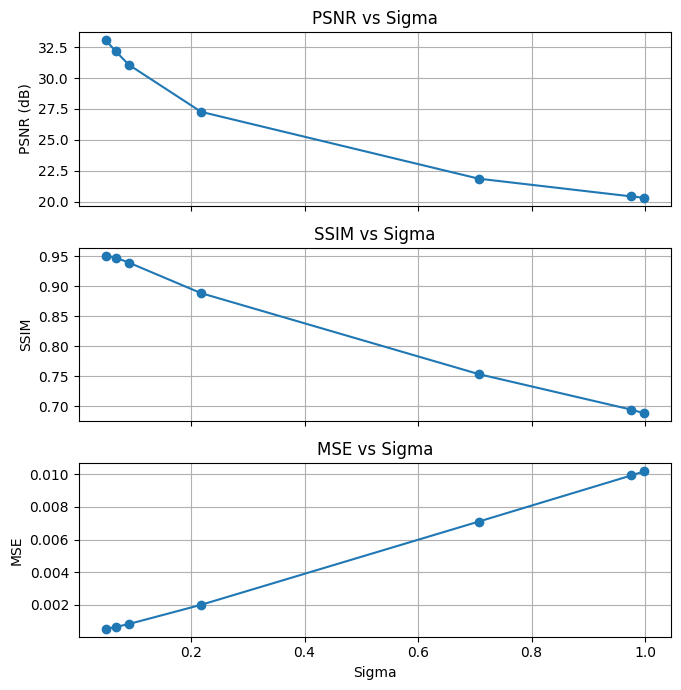

In [45]:
plot_metrics_against_sigma(df)

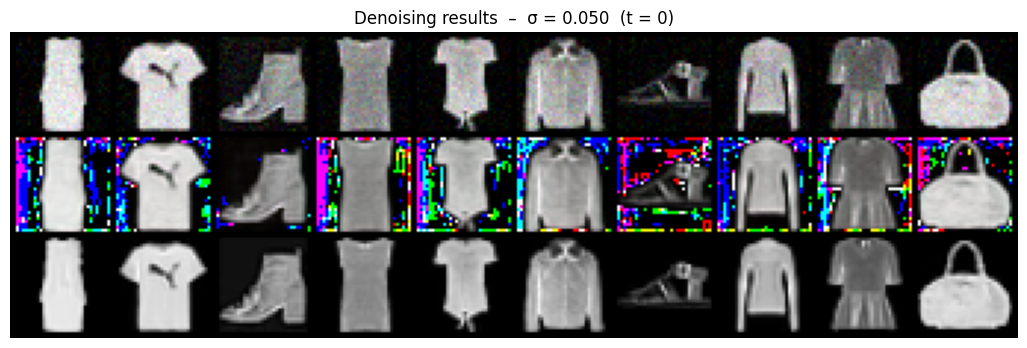

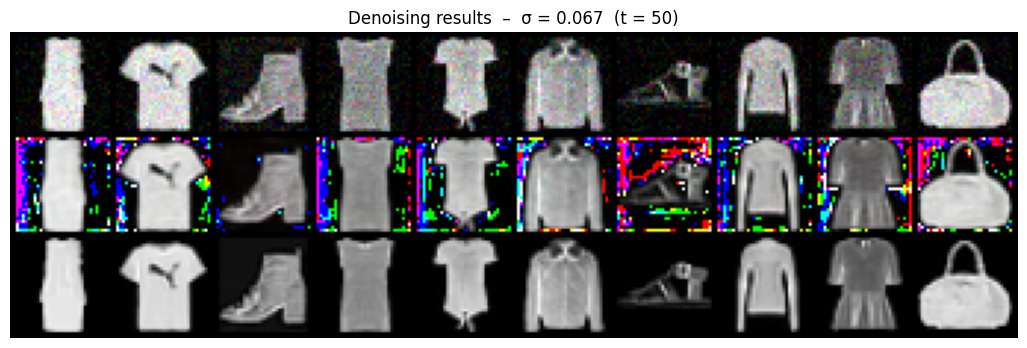

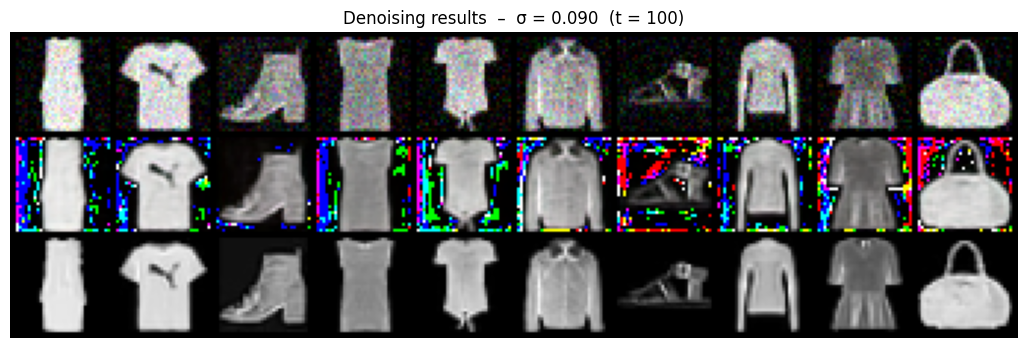

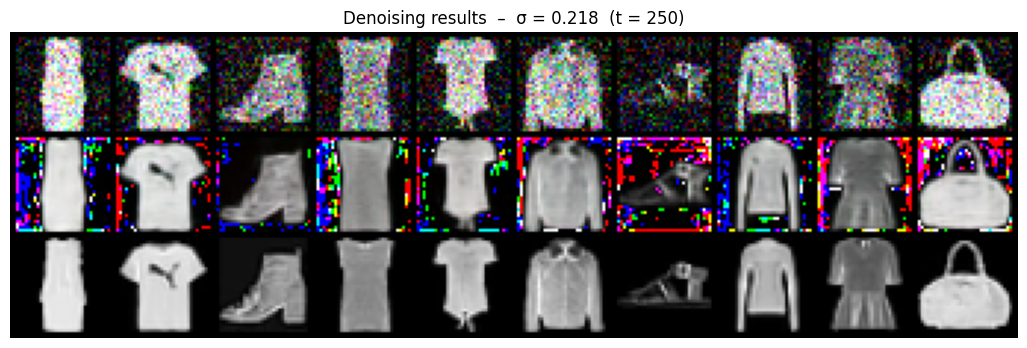

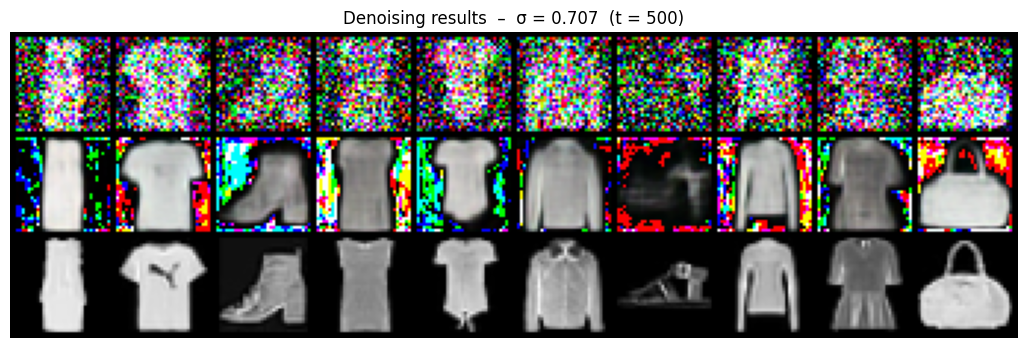

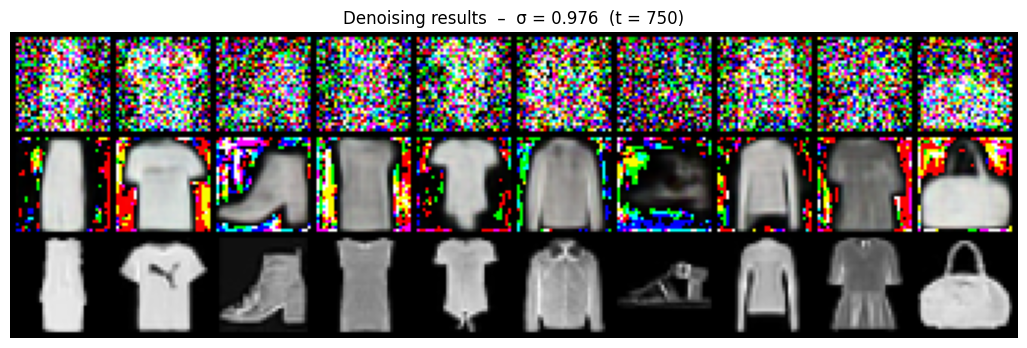

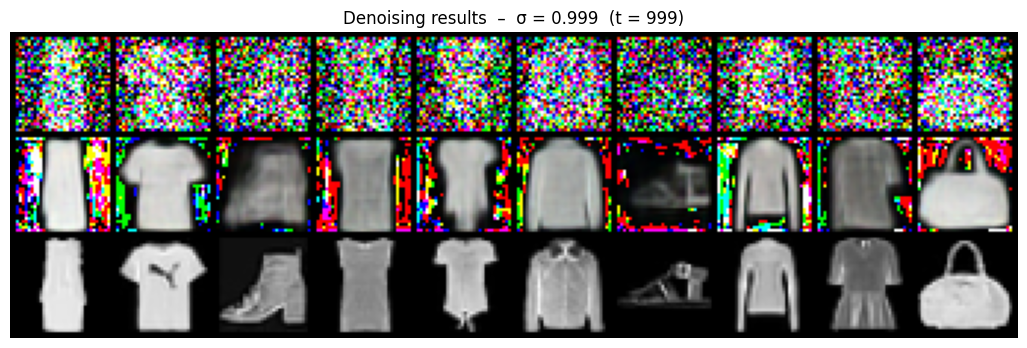

In [46]:
n_cols = 10                                       # images per row
row_titles = ["Noisy", "Denoised", "Clean"]

# choose n_cols random test indices once per run
indices = random.sample(range(len(test_set)), n_cols)
clean_subset = torch.stack([test_set[i][0] for i in indices]).to(device)

with torch.no_grad():
    for t, σ in zip(LEVELS, sigmas):
        noisy  = torch.clamp(clean_subset + torch.randn_like(clean_subset) * σ, 0., 1.)
        denoised = model(noisy,
                         torch.full((n_cols,), t, dtype=torch.long, device=device))

        # compose grid: row0=noisy, row1=denoised, row2=clean
        grid = torch.cat([noisy.cpu(),
                          denoised.cpu(),
                          clean_subset.cpu()], dim=0)
        grid = make_grid(grid, nrow=n_cols, padding=2)

        plt.figure(figsize=(1.3*n_cols, 4))
        plt.imshow(to_pil_image(grid))
        plt.axis("off")
        plt.title(f"Denoising results  –  σ = {σ:.3f}  (t = {t})")
        # for r, txt in enumerate(row_titles):
        #     plt.text(-0.5, (r+0.5)/3, txt, va="center",
        #              ha="right", fontsize=12, transform=plt.gca().transAxes)
        plt.show()

In [46]:
# from google.colab import runtime
# runtime.unassign()